In [1]:
!pip install efficientnet_pytorch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import pandas as pd
import numpy as np
import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from efficientnet_pytorch import EfficientNet
import matplotlib.pyplot as plt


import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore')

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정


import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [5]:
import os
import pandas as pd

dataset_path = os.listdir("/content/drive/MyDrive/data")
rooms = []
class_mapping = {}
class_counter = 0

for category in dataset_path:
    if category == 'normal':
        subfolders = os.listdir("/content/drive/MyDrive/data/" + category)
        for subfolder in subfolders:
            class_mapping[subfolder] = class_counter
            class_counter += 1
            all_rooms = os.listdir("/content/drive/MyDrive/data/" + category + "/" + subfolder)
            for room in all_rooms:
                rooms.append((subfolder, "/content/drive/MyDrive/data/" + category + "/" + subfolder + "/" + room))
    elif category == 'abnormal':
        subfolders = os.listdir("/content/drive/MyDrive/data/" + category)
        for subfolder in subfolders:
            class_mapping[subfolder] = class_counter
            class_counter += 1
            all_rooms = os.listdir("/content/drive/MyDrive/data/" + category + "/" + subfolder)
            for room in all_rooms:
                rooms.append((subfolder, "/content/drive/MyDrive/data/" + category + "/" + subfolder + "/" + room))

train_df = pd.DataFrame(data=rooms, columns=["tag", "video_name"])
data = train_df.loc[:, ["video_name", "tag"]]


data["tag"] = data["tag"].map(class_mapping)

# 인코딩 확인
print("Class mapping:")
print(class_mapping)
print("After encoding:")
print(data.head())

# 원-핫 인코딩
one_hot_labels = pd.get_dummies(data['tag'], prefix='class')
data = pd.concat([data, one_hot_labels], axis=1)

# 인코딩 확인
print("After one-hot encoding:")
print(data.head())

train = data.sample(frac=0.8, random_state=42)
tmp = data.drop(train.index)
valid = tmp.sample(frac=0.5, random_state=42)
test = tmp.drop(valid.index)

# train, valid, test 세트의 크기 출력
print("Train set size:", len(train))
print("Validation set size:", len(valid))
print("Test set size:", len(test))

train.to_csv("/content/drive/MyDrive/keb/train.csv")
valid.to_csv("/content/drive/MyDrive/keb/valid.csv")
test.to_csv("/content/drive/MyDrive/keb/test.csv")


Class mapping:
{'선택': 0, '시험': 1, '구매': 2, '반품': 3, '비교': 4, '이동': 5, '파손': 6, '절도': 7, '폭행': 8}
After encoding:
                                          video_name  tag
0  /content/drive/MyDrive/data/normal/선택/C_2_...    0
1  /content/drive/MyDrive/data/normal/선택/C_2_...    0
2  /content/drive/MyDrive/data/normal/선택/C_2_...    0
3  /content/drive/MyDrive/data/normal/선택/C_2_...    0
4  /content/drive/MyDrive/data/normal/선택/C_2_...    0
After one-hot encoding:
                                          video_name  tag  class_0  class_1  \
0  /content/drive/MyDrive/data/normal/선택/C_2_...    0        1        0   
1  /content/drive/MyDrive/data/normal/선택/C_2_...    0        1        0   
2  /content/drive/MyDrive/data/normal/선택/C_2_...    0        1        0   
3  /content/drive/MyDrive/data/normal/선택/C_2_...    0        1        0   
4  /content/drive/MyDrive/data/normal/선택/C_2_...    0        1        0   

   class_2  

In [6]:
train.head()

,video_name,tag,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8
5077,/content/drive/MyDrive/data/abnormal/절도/C_3...,7,0,0,0,0,0,0,0,1,0
2410,/content/drive/MyDrive/data/normal/비교/C_2_6_...,4,0,0,0,0,1,0,0,0,0
3520,/content/drive/MyDrive/data/normal/이동/C_1_1...,5,0,0,0,0,0,1,0,0,0
230,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0
378,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0


In [7]:
train = pd.read_csv("/content/drive/MyDrive/keb/train.csv",index_col=0)
valid = pd.read_csv("/content/drive/MyDrive/keb/valid.csv",index_col=0)
test = pd.read_csv("/content/drive/MyDrive/keb/test.csv",index_col=0)

In [8]:
train.head()

,video_name,tag,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8
5077,/content/drive/MyDrive/data/abnormal/절도/C_3...,7,0,0,0,0,0,0,0,1,0
2410,/content/drive/MyDrive/data/normal/비교/C_2_6_...,4,0,0,0,0,1,0,0,0,0
3520,/content/drive/MyDrive/data/normal/이동/C_1_1...,5,0,0,0,0,0,1,0,0,0
230,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0
378,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0


In [9]:
train["tag"].unique()

array([7, 4, 5, 0, 6, 1, 8, 3, 2])

In [10]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [11]:
class CustomDataset(Dataset):
  def __init__(self, video_path_list,label_list):
    self.video_path_list = video_path_list
    self.label_list = label_list

  def __getitem__(self, index):
    frames = self.get_video(self.video_path_list[index])
    if self.label_list is not None:
      label = self.label_list[index]
      return frames, label
    else:
      return frames

  def __len__(self):
    return len(self.video_path_list)

  def get_video(self, path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(77):
      _, img = cap.read()

      if img is not None:
        img = cv2.resize(img, (128,128))
        img = img/255
        frames.append(img)

    cap.release()

    # return torch.FloatTensor(np.array(frames)).permute(3,0,1,2)

    return torch.FloatTensor(np.array(frames)).permute(0,3,1,2)

  def check_frame(self, frames):
    return frames.shape

In [12]:
train.head()

,video_name,tag,class_0,class_1,class_2,class_3,class_4,class_5,class_6,class_7,class_8
5077,/content/drive/MyDrive/data/abnormal/절도/C_3...,7,0,0,0,0,0,0,0,1,0
2410,/content/drive/MyDrive/data/normal/비교/C_2_6_...,4,0,0,0,0,1,0,0,0,0
3520,/content/drive/MyDrive/data/normal/이동/C_1_1...,5,0,0,0,0,0,1,0,0,0
230,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0
378,/content/drive/MyDrive/data/normal/선택/C_2_...,0,1,0,0,0,0,0,0,0,0


In [13]:
train_dataset = CustomDataset(train["video_name"].values, train["tag"].values)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataset = CustomDataset(valid["video_name"].values, valid["tag"].values)
val_loader = DataLoader(val_dataset, batch_size =4, shuffle=False, num_workers=0)

In [14]:
class EfficientLstm(nn.Module):

  def  __init__(self, num_classes=9, in_channels=3):
    super(EfficientLstm, self).__init__()
    self.efficient = EfficientNet.from_pretrained('efficientnet-b0', in_channels=in_channels)
    self.lstm = nn.LSTM(input_size=1000, hidden_size=256, num_layers=3)
    self.fc1 = nn.Linear(256, num_classes)


  def forward(self, x_3d):
    hidden = None
    for t in range(x_3d.size(1)):
      with torch.no_grad():
        x = self.efficient(x_3d[:,t]) #4*1000

      out, hidden = self.lstm(x.unsqueeze(0), hidden) #1000*256

    x = F.relu(hidden[0][-1])
    x = self.fc1(x)

    return x






In [15]:
def validation(model, criterion, val_loader, device):
  model.eval()
  val_loss = []
  preds, trues = [],[]

  with torch.no_grad():
    for videos, labels in tqdm(iter(val_loader)):
      videos = videos.to(device)
      labels = labels.to(device)

      logit = model(videos)

      loss = criterion(logit, labels)
      val_loss.append(loss.item())

      preds +=logit.argmax(1).detach().cpu().numpy().tolist()
      trues += labels.detach().cpu().numpy().tolist()

    _val_loss = np.mean(val_loss)

  _val_score = f1_score(trues, preds, average="macro")
  return _val_loss, _val_score

In [34]:
def train_(model, optimizer, train_loader, val_loader, schedule, device):
  model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)

  best_val_score = 0
  best_model = None

  all_train_loss = {}
  all_val_loss = {}

  for epoch in range(1,2): #테스트 용이니까.
    model.train()
    train_loss=[]
    for videos, labels in tqdm(iter(train_loader)):
      videos = videos.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      output = model(videos)

      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    _val_loss, _val_score = validation(model, criterion, val_loader, device)
    _train_loss = np.mean(train_loss)
    all_train_loss[epoch] = _train_loss
    all_val_loss[epoch] = _val_loss
    print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val F1 : [{_val_score:.5f}]')

    if schedule is not None:
      schedule.step(_val_score)

    if best_val_score < _val_score:
      best_val_score = _val_score
      best_model = model

  return all_train_loss, all_val_loss,best_model

In [ ]:
model = EfficientLstm()
# model = CRNN()

model.eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2, threshold_mode="abs",
                                                      min_lr=1e-8, verbose=True)
all_train_loss, all_val_loss, infer_model = train_(model, optimizer, train_loader, val_loader, scheduler, device)

Loaded pretrained weights for efficientnet-b0


  0%|          | 0/1247 [00:00<?, ?it/s]

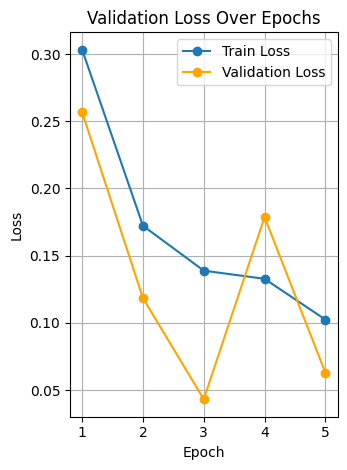

In [ ]:

plt.subplot(1, 2, 1)
plt.plot(list(all_train_loss.keys()), list(all_train_loss.values()), marker='o', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)

# 두 번째 subplot에 검증 손실 값을 그래프로 그립니다.
plt.subplot(1, 2, 1)
plt.plot(list(all_val_loss.keys()), list(all_val_loss.values()), marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()  # subplot 간 간격을 조절합니다.
plt.show()

In [ ]:
test_dataset = CustomDataset(test['video_name'].values, None)
test_loader = DataLoader(test_dataset, batch_size = 4, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    preds = []
    with torch.no_grad():
        for videos in tqdm(iter(test_loader)):
            videos = videos.to(device)
            print(videos)

            logit = model(videos)

            preds += logit.argmax(1).detach().cpu().numpy().tolist()
    return preds

In [ ]:
preds = inference(model, test_loader, device)

  0%|          | 0/24 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.


         ...,


         [[[0.1725, 0.3255, 0.1882,  ..., 0.3804, 0.3725, 0.2235],
           [0.1608, 0.2353, 0.1765,  ..., 0.3451, 0.3529, 0.1961],
           [0.1608, 0.1608, 0.1804,  ..., 0.3216, 0.4157, 0.2118],
           ...,
           [0.6510, 0.6510, 0.6510,  ..., 0.2392, 0.1804, 0.1569],
           [0.6510, 0.6510, 0.6549,  ..., 0.2510, 0.2000, 0.1216],
           [0.6510, 0.6510, 0.6431,  ..., 0.1059, 0.1020, 0.0980]],

          [[0.2000, 0.3647, 0.2039,  ..., 0.6549, 0.6510, 0.3922],
           [0.1882, 0.2745, 0.1922,  ..., 0.6196, 0.6078, 0.3412],
           [0.1882, 0.2000, 0.1882,  ..., 0.5804, 0.6510, 0.3373],
           ...,
           [0.5569, 0.5569, 0.5569,  ..., 0.3020, 0.3176, 0.2667],
           [0.5569, 0.5569, 0.5569,  ..., 0.2902, 0.2392, 0.1843],
           [0.5569, 0.5569, 0.5529,  ..., 0.1294, 0.1451, 0.1294]],

          [[0.1451, 0.3333, 0.1569,  ..., 0.4980, 0.4824, 0.2588],
           [0.1333, 0.2431, 0.1451,  ..

In [ ]:
import cv2
import numpy as np
import os
import torch
i = 0
def get_video(path):
    frames = []
    cap = cv2.VideoCapture(path)
    for _ in range(47):
      _, img = cap.read()

      if img is not None:
        img = cv2.resize(img, (128,128))
        img = img/255
        frames.append(img)

    cap.release()

    return torch.FloatTensor(np.array(frames)).permute(0,3,1,2).unsqueeze(0)

def predict_video(video_path):
    print("flag")
    video_tensor = get_video(video_path)
    video_tensor = video_tensor.to(device)

    with torch.no_grad():
        output = model(video_tensor)
        prediction = torch.argmax(output, dim=1).item()
    return "폭력" if prediction == 1 else "정상"

content_path = "/content/drive/MyDrive/keb/test_Violence"
video_files = [f for f in os.listdir(content_path) if f.endswith('.mp4')]
print(video_files)

total = 0
correct = 0
incorrect = []
for video_file in video_files:
    total +=1
    video_path = os.path.join(content_path, video_file)
    tmp = "/content/drive/MyDrive/keb/test_Violence/"
    video_file = tmp+video_file
    print(video_file)
    prediction_result = predict_video(video_path)
    if prediction_result == "폭력":
      i +=1
    else:
      incorrect.append(video_file)

    print(f"영상 이름: {video_file}, 분류: {prediction_result}")

print(i/total)

['V_110.mp4', 'V_115.mp4', 'V_114.mp4', 'V_105.mp4', 'V_107.mp4', 'V_103.mp4', 'V_1.mp4', 'V_116.mp4', 'V_100.mp4', 'V_112.mp4', 'V_111.mp4', 'V_108.mp4', 'V_11.mp4', 'V_10.mp4', 'V_109.mp4', 'V_1000.mp4', 'V_113.mp4', 'V_102.mp4', 'V_118.mp4', 'V_117.mp4', 'V_101.mp4', 'V_106.mp4', 'V_104.mp4', 'V_120.mp4', 'V_138.mp4', 'V_137.mp4', 'V_139.mp4', 'V_136.mp4', 'V_130.mp4', 'V_129.mp4', 'V_14.mp4', 'V_123.mp4', 'V_122.mp4', 'V_131.mp4', 'V_128.mp4', 'V_125.mp4', 'V_121.mp4', 'V_126.mp4', 'V_132.mp4', 'V_124.mp4', 'V_119.mp4', 'V_127.mp4', 'V_133.mp4', 'V_13.mp4', 'V_135.mp4', 'V_12.mp4', 'V_134.mp4', 'V_140.mp4', 'V_165.mp4', 'V_169.mp4', 'V_161.mp4', 'V_163.mp4', 'V_150.mp4', 'V_168.mp4', 'V_146.mp4', 'V_142.mp4', 'V_148.mp4', 'V_170.mp4', 'V_144.mp4', 'V_158.mp4', 'V_164.mp4', 'V_155.mp4', 'V_15.mp4', 'V_152.mp4', 'V_154.mp4', 'V_167.mp4', 'V_153.mp4', 'V_156.mp4', 'V_141.mp4', 'V_162.mp4', 'V_166.mp4', 'V_157.mp4', 'V_149.mp4', 'V_145.mp4', 'V_159.mp4', 'V_147.mp4', 'V_17.mp4', 'V_151